# Predicting Hospitalization Costs

Chris Defreitas

Fall 2018

Bryant University

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.ticker as mtick
#IMG_PATH = 'C:\\Users\\student\\Documents\\Bryant\\4_Senior\\MATH 490 - Capstone\\Presentation\\'

In [2]:
import warnings
warnings.filterwarnings('ignore')

Import dataset

In [3]:
dtype = {'admtype': 'int8',
 'age': 'float16',
 'asource': 'category',
 'campus': 'category',
 'diag_adm': 'category',
 'diag_cat3': 'category',
 'diag_cat4': 'category',
 'er_mode': 'int8',
 'moa': 'int8',
 'pay_ub92': 'int8',
 'provider': 'int8',
 'pt_state': 'category',
 'race': 'int8',
 'sex': 'int8',
 'tot': 'float64',
 'yoa': 'int8'}

In [4]:
df0_full = pd.read_csv('df_cleansed2.csv', dtype=dtype, low_memory=False)

In [5]:
df0_full.head()

,pay_ub92,age,sex,provider,moa,yoa,admtype,asource,tot,pt_state,diag_adm,campus,er_mode,race,diag_cat3,diag_cat4
0,6,87.0,2,10,2,5,1,7,3412.0,RI,486,0,0,1,486,486
1,6,38.0,1,10,2,5,1,7,4132.0,RI,5128,0,0,1,512,5128
2,6,22.0,2,10,2,5,1,9,12583.0,RI,29650,0,0,1,296,2965
3,6,45.0,2,10,1,5,1,7,17462.0,RI,7850,0,0,1,785,7850
4,6,26.0,2,10,1,5,2,1,10357.0,RI,650,0,0,9,650,650


In [6]:
df0_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972363 entries, 0 to 972362
Data columns (total 16 columns):
pay_ub92     972363 non-null int8
age          972363 non-null float16
sex          972363 non-null int8
provider     972363 non-null int8
moa          972363 non-null int8
yoa          972363 non-null int8
admtype      972363 non-null int8
asource      972363 non-null category
tot          972363 non-null float64
pt_state     972363 non-null category
diag_adm     972363 non-null category
campus       972363 non-null category
er_mode      972363 non-null int8
race         972363 non-null int8
diag_cat3    972363 non-null category
diag_cat4    972363 non-null category
dtypes: category(6), float16(1), float64(1), int8(8)
memory usage: 25.5 MB


## Transform Data

In [7]:
df1 = df0_full.copy()

In [8]:
seasons = {12: 'winter', 1: 'winter', 2: 'winter',
           3: 'spring', 4: 'spring', 5: 'spring',
           6: 'summer', 7: 'summer', 8: 'summer',
           9: 'fall', 10: 'fall', 11: 'fall'}

In [9]:
df1['moa'] = df1['moa'].map(seasons).astype('category')

In [10]:
df1['moa'].head()

0    winter
1    winter
2    winter
3    winter
4    winter
Name: moa, dtype: category
Categories (4, object): [fall, spring, summer, winter]

## Split data set into Train and Test

In [11]:
train_index = pd.read_csv("Train_Index.csv")
test_index = pd.read_csv("Test_Index.csv")

In [12]:
train = df1.loc[train_index['0']]

In [13]:
test = df1.loc[test_index['0']]

In [14]:
X_train = train.drop(columns=['tot'])
X_test = test.drop(columns=['tot'])
y_train = train.tot.astype(float)
y_test = test.tot.astype(float)

In [15]:
X_train.shape

(968362, 15)

In [16]:
X_test.shape

(4000, 15)

## CatBoost

In [17]:
from catboost import Pool, CatBoostRegressor

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [19]:
# initialize Pool
cat_features = [0, 2, 3, 4, 6, 7]
cat_features.extend(range(8, len(X_train.columns)))
print(cat_features)
print(X_train.columns[cat_features])

[0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Index(['pay_ub92', 'sex', 'provider', 'moa', 'admtype', 'asource', 'pt_state',
       'diag_adm', 'campus', 'er_mode', 'race', 'diag_cat3', 'diag_cat4'],
      dtype='object')


In [20]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features) 

In [21]:
# Play a been when the champion model is beat
CHAMPION_SCORE = 0
import winsound
def chicken_dinner():
    winsound.Beep(2500, 50)

In [22]:
def get_champion_score(score):
    global CHAMPION_SCORE
    if score > CHAMPION_SCORE:
        chicken_dinner()
        CHAMPION_SCORE = score
        print("New champion score!", score)
    else:
        print("Score to beat", CHAMPION_SCORE)

In [23]:
def score_model(train_predicted, test_predicted, y_train, y_test):
    rmse_train = mean_squared_error(y_train, train_predicted)**.5
    rmse_test = mean_squared_error(y_test, test_predicted)**.5
    r2_train = r2_score(y_train, train_predicted)
    r2_test = r2_score(y_test, test_predicted)
    print("Train RMSE:\t{}".format(rmse_train))
    print("Test RMSE:\t{}".format(rmse_test))
    print("Train r2:\t{}".format(r2_train))
    print("Test r2:\t{}".format(r2_test))
    get_champion_score(r2_test)
    return r2_test

In [24]:
def fit_model(params, cat_features=cat_features, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, cat_features=cat_features)
    model = CatBoostRegressor(**params)
    
    #train the model
    model.fit(train_pool)
    
    # make the prediction using the resulting model
    train_predicted = model.predict(train_pool)
    test_predicted = model.predict(test_pool)
    
    metric = score_model(train_predicted, test_predicted, y_train, y_test)
    
    return model, metric

## Train Model (Run in computer lab)

In [25]:
'''# specify the training parameters 
#model = CatBoostRegressor(iterations=2, depth=2, learning_rate=1, loss_function='RMSE')
model = CatBoostRegressor(iterations=10, loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
predicted = model.predict(test_pool)
#print(preds)'''

"# specify the training parameters \n#model = CatBoostRegressor(iterations=2, depth=2, learning_rate=1, loss_function='RMSE')\nmodel = CatBoostRegressor(iterations=10, loss_function='RMSE')\n#train the model\nmodel.fit(train_pool)\n# make the prediction using the resulting model\npredicted = model.predict(test_pool)\n#print(preds)"

In [26]:
'''fi = model.get_feature_importance()
for i in range(len(X_train.columns)):
    print(X_train.columns[i], '\t', fi[i])'''

"fi = model.get_feature_importance()\nfor i in range(len(X_train.columns)):\n    print(X_train.columns[i], '\t', fi[i])"

In [27]:
'''models = {}'''

'models = {}'

In [28]:
'''m, s = fit_model({'iterations': 100})
model_name = '100 iter'
models[model_name] = m, s'''

"m, s = fit_model({'iterations': 100})\nmodel_name = '100 iter'\nmodels[model_name] = m, s"

In [29]:
'''m, s = fit_model({'iterations': 100, 'depth': 2})
model_name = '100 iter 2 depth'
models[model_name] = m, s'''

"m, s = fit_model({'iterations': 100, 'depth': 2})\nmodel_name = '100 iter 2 depth'\nmodels[model_name] = m, s"

In [30]:
'''for d in range(6, 0, -1):
    m, s = fit_model({'iterations': 1000, 'depth': d})
    model_name = '{} depth'.format(d)
    models[model_name] = m, s'''

"for d in range(6, 0, -1):\n    m, s = fit_model({'iterations': 1000, 'depth': d})\n    model_name = '{} depth'.format(d)\n    models[model_name] = m, s"

In [31]:
'''for i in [10, 100, 1000, 10000]:
    for d in [6]:
        m, s = fit_model({'iterations': i, 'depth': d})
        model_name = '{} iterations and {} depth'.format(i, d)
        models[model_name] = m, s'''

"for i in [10, 100, 1000, 10000]:\n    for d in [6]:\n        m, s = fit_model({'iterations': i, 'depth': d})\n        model_name = '{} iterations and {} depth'.format(i, d)\n        models[model_name] = m, s"

#### Model Selection

In [32]:
'''pprint(models)'''

'pprint(models)'

In [33]:
'''mdl = models['6 depth'][0]'''

"mdl = models['6 depth'][0]"

In [34]:
'''fi = mdl.get_feature_importance()
for i in range(len(X_train.columns)):
    print(X_train.columns[i], '\t', fi[i])'''

"fi = mdl.get_feature_importance()\nfor i in range(len(X_train.columns)):\n    print(X_train.columns[i], '\t', fi[i])"

#### Pickling Models for later use

In [35]:
'''# https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostregressor_save_model-docpage/
for k, v in models.items():
    v[0].save_model("{}_11-9-18.mlmodel".format(k))'''

'# https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostregressor_save_model-docpage/\nfor k, v in models.items():\n    v[0].save_model("{}_11-9-18.mlmodel".format(k))'

## Opening Pickled Model

In [36]:
model = CatBoostRegressor()
model.load_model('6 depth_11-9-18.mlmodel', format='catboost')

In [37]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [38]:
# make the prediction using the resulting model
train_predicted = model.predict(train_pool)
test_predicted = model.predict(test_pool)

metric = score_model(train_predicted, test_predicted, y_train, y_test)

Train RMSE:	5511.761726653353
Test RMSE:	5721.813914716679
Train r2:	0.4461194049137549
Test r2:	0.37374360862107414
New champion score! 0.37374360862107414


In [39]:
plt.style.use('seaborn-talk')

In [40]:
df_residuals = pd.DataFrame(columns=['predicted', 'actual'])

In [41]:
df_residuals['predicted'] = test_predicted

In [42]:
df_residuals['actual'] = y_test.reset_index()['tot']

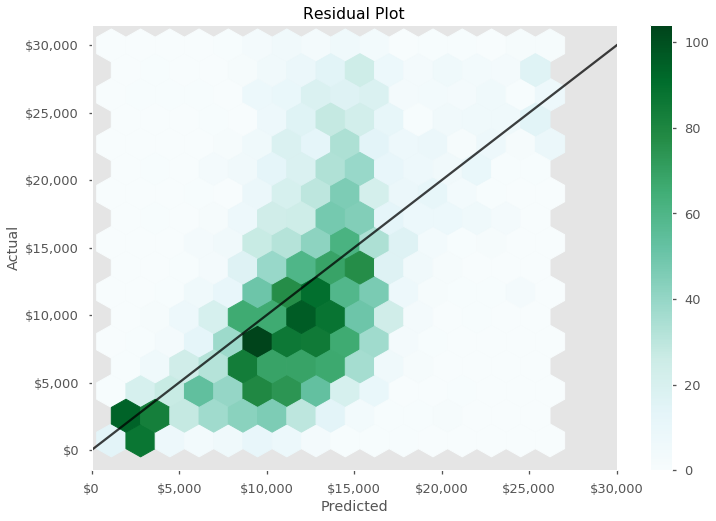

In [43]:
fig, ax = plt.subplots()

# plot residual heat map
df_residuals.plot(kind='hexbin', x='predicted', y='actual', gridsize=15, sharex=False, xlim=(0,30000), ax=ax)

# now plot the identiy line
ax.plot([0, 30000], [0, 30000], 'k-', alpha=.75)

# format
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.set_title("Residual Plot")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.grid(None)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.savefig(IMG_PATH + 'Residual.png', dpi=300)

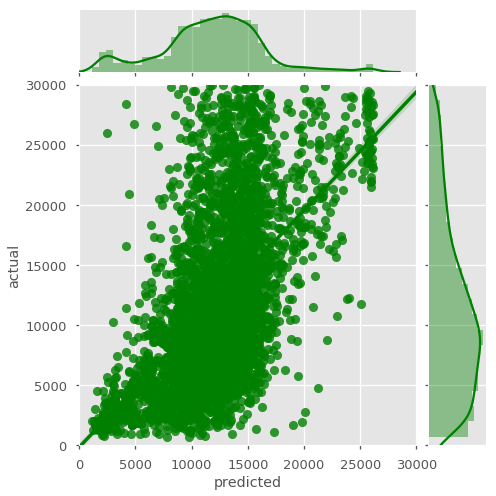

In [44]:
ax = sns.jointplot("predicted", "actual", data=df_residuals, kind="reg",
                  xlim=(0, 30000), ylim=(0, 30000), color="g", height=7)